In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#checking to see what columns are in measurement table
measurement_columns = inspect(engine).get_columns('Measurement')
for x in measurement_columns:
    print(x['name'], x['type'])

print("-------------------")

#checking to see what columns are in station table
station_columns = inspect(engine).get_columns('Station')
for x in station_columns:
    print(x['name'], x['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

<Axes: xlabel='Date', ylabel='Precipitation'>

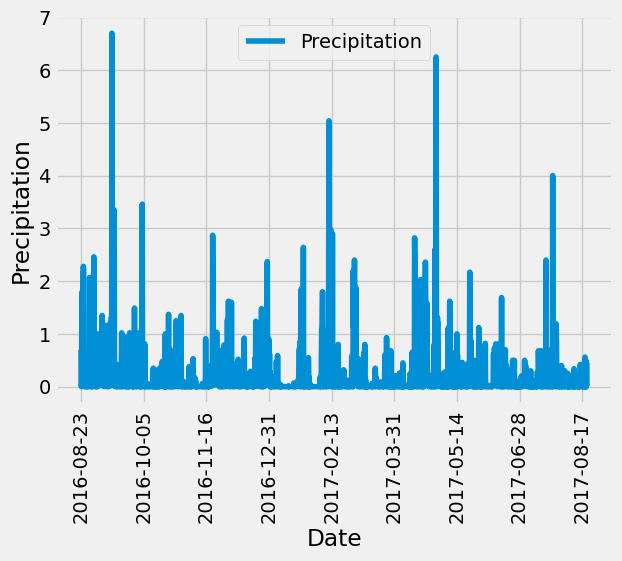

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
one_year_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date.desc()).all()

one_year_precip

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(one_year_precip, columns = ['Date','Precipitation']).dropna()
precip_df

# Sort the dataframe by date 
precip_df = precip_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot.line(x='Date', y= 'Precipitation', xlabel ='Date', ylabel='Precipitation', rot = 90)





In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = precip_df['Precipitation'].count()
mean = precip_df['Precipitation'].mean()
std = precip_df['Precipitation'].std()
min = precip_df['Precipitation'].min()
twenty_five = precip_df['Precipitation'].quantile(0.25)
fifty = precip_df['Precipitation'].quantile(0.50)
seventy_five = precip_df['Precipitation'].quantile(0.75)
max = precip_df['Precipitation'].max()

precip_summary = pd.DataFrame({'stat': ['count', 'mean', 'std', 'min', '25%', 
                                                '50%', '75%', 'max'],
                               'precipitation': [count, mean, std, min, twenty_five, 
                               fifty, seventy_five, max]})

precip_summary

,stat,precipitation
0,count,2021.000000
1,mean,0.177279
2,std,0.461190
3,min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
    
for station in activity:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
main_station = 'USC00519281'

main_station_temps = session.query(func.min(Measurement.tobs), 
              func.max(Measurement.tobs), 
              func.avg(Measurement.tobs)).\
              filter_by(station = main_station)

for result in main_station_temps:
    print(result)



(54.0, 85.0, 71.66378066378067)


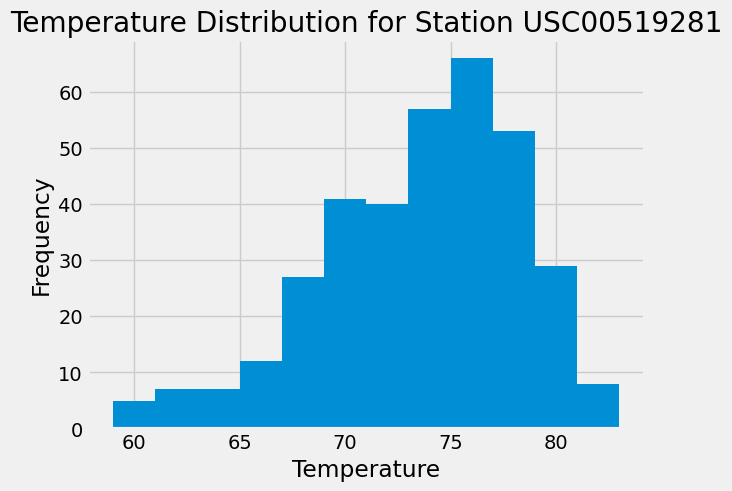

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == main_station).\
    filter(Measurement.date >= year_ago).all()

one_year_temp_df = pd.DataFrame(one_year_temp)

plt.hist(one_year_temp_df['tobs'], bins=12)

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution for Station USC00519281')

plt.show()

# Close Session

In [17]:
# Close Session
session.close()